# Quantitative sensitivity analysis


## Generalized Sobol Indices

Here we show how to compute generalized Sobol indices on the **EOQ** model using the algorithm presented in Kucherenko et al. 2012. We import our model function from ``temfpy`` and use the Kucherenko indices function from ``econsa``. 

In [1]:
import matplotlib.pyplot as plt  # noqa: F401
import numpy as np

from temfpy.uncertainty_quantification import eoq_model

# TODO: Reactivate once Tim's PR is ready.
# from econsa.kucherenko import kucherenko_indices  # noqa: E265

The function ``kucherenko_indices`` expects the input function to be broadcastable over rows, that is, a row represents the input arguments for one evaluation. For sampling around the mean parameters we specify a diagonal covariance matrix, where the variances depend on the scaling of the mean. Since the variances of the parameters are unknown prior to our analysis we choose values such that the probability of sampling negative values is negligible. We do this since the **EOQ** model is not defined for negative parameters and the normal sampling does not naturally account for bounds.

In [2]:
def eoq_model_transposed(x):
    """EOQ Model but with variables stored in columns."""
    return eoq_model(x.T)

mean = np.array([1230, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

# indices = kucherenko_indices( # noqa: E265
#    func=eoq_model_transposed, # noqa: E265
#    sampling_mean=mean,  # noqa: E265
#    sampling_cov=cov,  # noqa: E265
#    n_draws=1_000_000,  # noqa: E265
#    sampling_scheme="sobol",  # noqa: E265
# )  # noqa: E265

Now we are ready to inspect the results.

In [3]:
# sobol_first = indices.loc[(slice(None), "first_order"), "value"].values  # noqa: E265
# sobol_total = indices.loc[(slice(None), "total"), "value"].values # noqa: E265

# x = np.arange(3)  # the label locations  # noqa: E265
# width = 0.35  # the width of the bars  # noqa: E265

# fig, ax = plt.subplots()  # noqa: E265
# rects1 = ax.bar(x - width / 2, sobol_first, width, label="First-order")  # noqa: E265
# rects2 = ax.bar(x + width / 2, sobol_total, width, label="Total")  # noqa: E265

# ax.set_ylim([0, 1])  # noqa: E265
# ax.legend()  # noqa: E265

# ax.set_xticks(x)  # noqa: E265
# ax.set_xticklabels(["$x_0$", "$x_1$", "$x_2$"])  # noqa: E265
# ax.legend();  # noqa: E265

In [4]:
# fig  # noqa: E265

## Shapley Effects

`econsa` offers an implementation of the algorithm for the computation of Shapley effects as propsoed by Song et al. (2016).
Here we show how to compute Shapley effects using the **EOQ** model as referenced above. We adjust the model in ``temfpy`` to accomodate an n-dimensional array for use in the context of the Shapley effects as implemented in ``econsa``. 

In [6]:
# import necessary packages and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chaospy as cp

from econsa.shapley import get_shapley
from econsa.shapley import _r_condmvn

#### Sampling via `x_all` and `x_cond`, and the model of interest `model`
First, we load all neccesary objects for the estimation of Shapley effects. The following objects are needed in the case of Gaussian model inputs.

- The functions ``x_all`` and ``x_cond`` for (un-)conditional sampling. These functions depend on the distribution from which we are sampling from. For the purposes of this illustration, we will sample from a multivariate normal distribution, but the functions can be tailored to the user's specific needs.

- A mean vector and covariance matrix of the model inputs. They are necessary for sampling conducted by the above two functions in the case of a Gaussian distribution.

- The ``model`` the user wishes to perform sensitivity analysis (SA) on that maps model inputs to a model output. Here we consider the **EOQ** model.

In [7]:
# Mean vector and covariance matrix of the model inputs.
n_inputs = 3
mean = np.array([5.345, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])

### Choosing `n_perms`
Since we are conducting SA on a model with three inputs, the number of permutations on which the computation algorithm is based is $3! = 6$. For larger number of inputs it might be worthwhile to consider only a subset of all permutations. E.g. for a model with 10 inputs, there are 3,628,800 permutations. Considering all permutations could be computationally infeasible. Thus, ``get_shapley`` allows the user to set a specific number of permutations by the argument ``n_perms``.

### Choosing the number of Monte Carlo (MC) runs `n_output`, `n_outer`, and `n_inner`
$N_V$, $N_O$, and $N_I$ denote the function arguments ``n_output``, ``n_outer``, and ``n_inner``, respectively. For the algorithm by Song et al. (2016) these three MC simulations are needed. The number of model evaluations required for the estimation of Shapley effects by ``get_shapley`` are given by

$$N_V+m \cdot N_I \cdot N_O \cdot (k-1),$$

where $m$ denotes the number of permutations, ``n_perms``, and $k$ the number of inputs, ``n_inputs``.

Song et al. (2016) show that choosing $N_I = 3$ is optimal. $N_V$ needs to be large enough to reliably estimate the total output variance, $V[Y]$. Given these choices, $N_O$ is chosen to consume the rest of the computational budget.

In [8]:
# Model for which senstivity analysis is being performed.
def eoq_model_ndarray(x, r=0.1):
    """EOQ Model that accepts ndarray."""
    m = x[:, 0]
    c = x[:, 1]
    s = x[:, 2]    
    return np.sqrt((24 * m * s) / (r * c))    

In [9]:
# Function for unconditional sampling.
def x_all(n):
    distribution = cp.MvNormal(mean, cov)
    return distribution.sample(n)

# Function for conditional sampling in the case of Gaussian inputs.
def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis = 1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(n, mean=mean, cov=cov, dependent_ind=subset_j, given_ind=subsetj_conditional, x_given=xjc)

In [11]:
# Estimate Shapley effects using the exact method.
np.random.seed(1234)
method = "exact"
n_perms = None
n_output = 10 ** 4
n_outer = 10 ** 3
n_inner = 3

exact_shapley = get_shapley(method, eoq_model_ndarray, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

In [12]:
exact_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,0.828423,0.008709,0.811353,0.845493
X2,0.130322,0.004717,0.121077,0.139568
X3,0.041255,0.012115,0.017509,0.065000


In [13]:
# Estimate Shapley effects using the random method.
np.random.seed(1234)
method = "random"
n_perms = 5
n_output = 10 ** 4
n_outer = 10 ** 3
n_inner = 3

random_shapley = get_shapley(method, eoq_model_ndarray, x_all, x_cond, n_perms, n_inputs, n_output, n_outer, n_inner)

In [15]:
random_shapley

,Shapley effects,std. errors,CI_min,CI_max
X1,0.817302,0.015392,0.787134,0.847470
X2,0.129110,0.003608,0.122037,0.136182
X3,0.053588,0.013530,0.027069,0.080108


Now we plot the ranking of the Shapley values below.

In [16]:
# comparison of exact and random method ranking
data = {'inputs':['X1', 'X2', 'X3'], 'exact_method':[0.814539, 0.130068, 0.055392],
        'random_method': [0.814734, 0.130517, 0.054749]}

# covert dict to dataframe for plot
df = pd.DataFrame(data)

# Set up a grid to plot survival probability against several variables
def ranking(data):
    g = sns.PairGrid(data.sort_values("exact_method", ascending=False),
                     x_vars=data.columns[-2:], y_vars=["inputs"],
                     height=4, aspect=.9)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=10, orient="h", linewidth=1, edgecolor="w")

    # Use the same x axis limits on all columns and add better labels
    g.set(xlim=(0, 0.9), xlabel="Shapley effect", ylabel="")

    # Use semantically meaningful titles for the columns
    titles = ["exact method", "random method"]

    for ax, title in zip(g.axes.flat, titles):

        # Set a different title for each axes
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

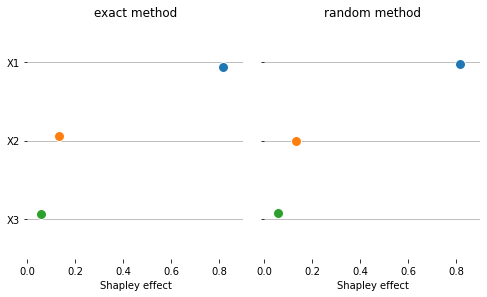

In [17]:
# plot for exact and random permutations methods
ranking(data = df)

As noticed above, both methods produce the same ranking. Sometimes, it is neccesary to compare the parameter estimates with their parameter values. A typical application is hypothesis testing, that is, whether the parameter estimates are significant, and what the contribution of significant / insignificant estimates is to the output variance as reflected by their Shapley ranking.

We can plot the parameter estimates together with their Shapley ranking as shown below:

In [18]:
# plot for exact permutations method
def ranking_params_shapley(ordered_df):
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
    plt.hlines(y=my_range, xmin=ordered_df['params'], xmax=ordered_df['shapley_effect'], color='grey', alpha=0.4)
    plt.scatter(ordered_df['params'], my_range, color='skyblue', alpha=1, label='params')
    plt.scatter(ordered_df['shapley_effect'], my_range, color='green', alpha=0.4 , label='shapley_effect')
    plt.legend()
     
    # Add title and axis names
    plt.yticks(my_range, ordered_df['inputs'])
    plt.title("Comparison of params and Shapley effects", loc='left')
    plt.xlabel('Value of the variables')
    plt.ylabel('Group')
    
df = {'inputs':['X1', 'X2', 'X3'], 'params':[5.345, 0.0135, 2.15],
        'shapley_effect': [0.814539, 0.130068, 0.055392]}

df_exact = pd.DataFrame(df)
ordered_df = df_exact.sort_values(by='params')
my_range = range(1,len(df_exact.index)+1)


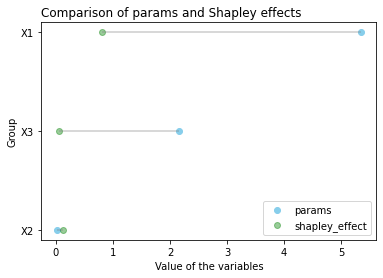

In [19]:
# plot exact method comparison
ranking_params_shapley(ordered_df)

In [20]:
# plot random method comparison
df = {'inputs':['X1', 'X2', 'X3'], 'params':[5.345, 0.0135, 2.15],
        'shapley_effect': [0.814734, 0.130517, 0.054749]}

df_exact = pd.DataFrame(df)
ordered_df = df_exact.sort_values(by='params')
my_range = range(1,len(df_exact.index)+1)


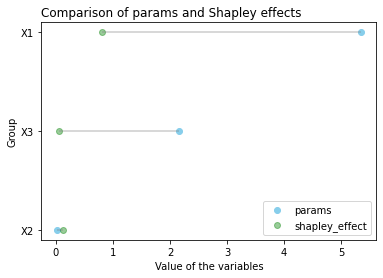

In [21]:
# plot random method comparison
ranking_params_shapley(ordered_df)

### When do we use randomly sampled permutations? Choosing `method`
The `exact` method is good for use when the number of parameters is low, depending on the computational time it takes to estimate the model in question. If it is computationally inexpensive to estimate the model for which sensitivity analysis is required, then the `exact` method is always preferable, otherwise the `random` is recommended. A good way to proceed if one suspects that the computational time required to estimate the model is high, having a lot of parameters to conduct SA on is always to commence the exercise with a small number of parameters, e.g. 3, then get a benchmark of the Shapley effects using the `exact` method. Having done that, repeat the exercise using the `random` method on the same vector of parameters, calibrating the `n_perms` argument to make sure that the results produced by the `random` method are the same as the `exact` one. Once this is complete, scale up the exercise using the `random` method, increasing the number of parameters to the desired parameter vector.

## Quantile Based Sensitivity Measures

We show how to compute global sensitivity measures based on quantiles of model's output.

In [19]:
# import necessary packages and functions
import numpy as np
import pandas as pd
import chaospy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from temfpy.uncertainty_quantification import eoq_model
from econsa.quantile_measures import mc_quantile_measures

Firstly, we specify the parameters of the function. This function `mc_quantile_measures` is capable of computing numerical results of quantile-based sensitivity measures on various user-provided models. Here we take **EOQ model** from `temfpy` as an example, where the model function is adjusted to accommodate an n-dimensional array. For multivariate distributed samples, the `loc` and `scale` keywords are denoted by a mean vector and a covariance matrix respectively. Considering both efficient computation and good convergence, we set `n_draws` equal to 3000 and  $2^{13}$  for brute force and double loop reordering estimators correspondently. Note that the double loop reordering estimator is more efficient than the brute force estimator.

In [20]:
# model to perform quantile based sensitivity ananlysis
def eoq_model_transposed(x):
    """EOQ Model but with variables stored in columns."""
    return eoq_model(x.T)

In [21]:
# mean and covaraince matrix inputs
mean = np.array([5.345, 0.0135, 2.15])
cov = np.diag([1, 0.000001, 0.01])
n_params = len(mean)
dist_type = "Normal"

Then we are ready to calculate the numerical results using the algorithm presented in Kucherenko et al. 2019.

In [22]:
# compute quantile measures using brute force estimator
bf_measures = mc_quantile_measures("brute force", eoq_model_transposed, n_params, mean, cov, dist_type, 3000,)

In [23]:
bf_measures

x_1        x_2       x_3
Measures alpha                                
q_1      0.020  64.010462  10.595192  6.522037
         0.052  53.565287  11.764802  7.126140
         0.084  47.203635  11.849184  7.315335
         0.116  43.584702  11.945758  7.390247
         0.148  40.746792  12.074625  7.493912
...                   ...        ...       ...
Q_2      0.852   0.851180   0.108055  0.040765
         0.884   0.857788   0.102897  0.039315
         0.916   0.863797   0.099314  0.036889
         0.948   0.871352   0.093822  0.034825
         0.980   0.880632   0.089250  0.030119

[124 rows x 3 columns]

In [24]:
# compute quantile measures using double loop reordering estimator
dlr_measures = mc_quantile_measures("DLR", eoq_model_transposed, n_params, mean, cov, dist_type, 2 ** 13,)

In [25]:
dlr_measures

x_1        x_2       x_3
Measures alpha                                
q_1      0.020  64.179809  10.414823  6.285291
         0.052  52.267399  11.037341  6.778817
         0.084  46.311146  11.211302  6.917412
         0.116  42.563103  11.407816  7.013578
         0.148  40.321098  11.638289  7.183969
...                   ...        ...       ...
Q_2      0.852   0.865417   0.097312  0.037271
         0.884   0.871006   0.093422  0.035572
         0.916   0.876810   0.089801  0.033388
         0.948   0.883911   0.084970  0.031119
         0.980   0.890728   0.081605  0.027667

[124 rows x 3 columns]

Now we are able to visualize the results.

In [26]:
def plot_quantile_measures(df_measures):
    
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5)

    fig, ax = plt.subplots(figsize=(8,6))
    
    n_params = len(df_measures.columns)

    style_1 = [f'C{i}s--' for i in range(n_params)]
    style_2 = [f'C{i}o--' for i in range(n_params)]

    for q, s in zip(["Q_1", "Q_2"], [style_1, style_2]):
        df_measures.loc[q].plot(ax=ax, style=s, markerfacecolor='none')

    ax.set_title(r"Values of $Q_i^{(1)}$ and $Q_i^{(2)}$ versus $\alpha$")
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_ylabel("Measures")
    ax.set_xlabel(r"$\alpha$")

    labels = [f'$Q_{i+1}^{{({p})}}$' for p in [1,2] for i in range(n_params)]    
    ax.legend(labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

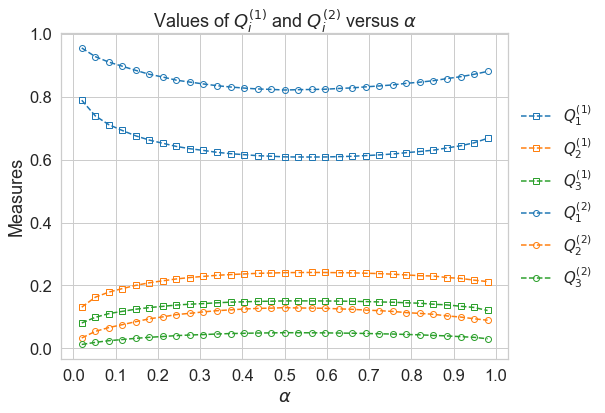

In [27]:
# plot brute force estimates
plot_quantile_measures(bf_measures)

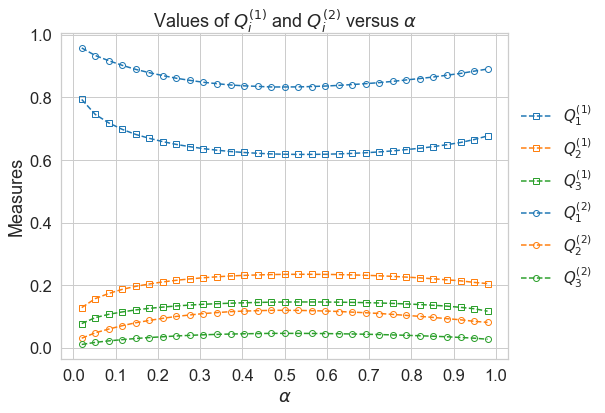

In [28]:
# plot double loop reordering estimates
plot_quantile_measures(dlr_measures)

The brute force estimator and DLR estimator generate the same ranking of variables for all quantiles: $x_1, x_2, x_3$(in descending order). At $\alpha=0.5$, measures $Q_i$ reachs their minimun:$i=1$ and maximum:$i=2,3$.